In [1]:
#mounting gdrive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/Dataset/kaggle_dataset/cat-dog-panda.zip

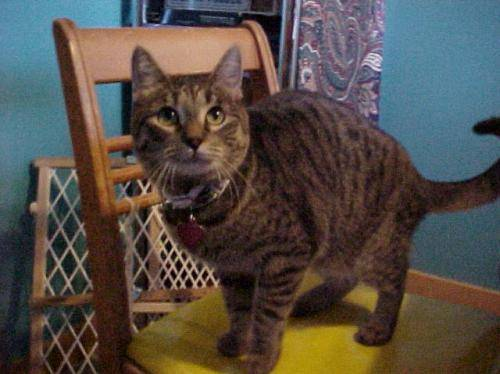

In [22]:
import cv2
from google.colab.patches import cv2_imshow
img=cv2.imread('/content/animals/animals/cats/cats_00001.jpg')
cv2_imshow(img)

In [7]:
import tensorflow as tf
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping

In [32]:
class myCallback(tf.keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs={}):
            DESIRED_LOSS = 0.3978
            if(logs.get('val_loss') < DESIRED_LOSS):
                print("\nReached 80% accuracy, terminating training processes...")
                self.model.stop_training = True

callbacks= myCallback()

In [12]:
import os #impor modul os untuk akses folder data
pic_kucing=os.path.join('/content/animals/animals/cats') #definisi folder training untuk gunting
pic_anjing=os.path.join('/content/animals/animals/dogs')
pic_panda=os.path.join('/content/animals/animals/panda')
total_images = len(os.listdir(pic_kucing)) + len(os.listdir(pic_anjing)) + len(os.listdir(pic_panda))

print("Gambar kucing sebanyak:",len(os.listdir(pic_kucing)))
print("Gambar anjing sebanyak:",len(os.listdir(pic_anjing)))
print("Gambar panda sebanyak:",len(os.listdir(pic_panda)))
print('===============================+')
print("Total Gambar:",total_images)

Gambar kucing sebanyak: 1000
Gambar anjing sebanyak: 1000
Gambar panda sebanyak: 1000
===============================+
Total Gambar: 3000


In [23]:
import random
import math
from shutil import copyfile

def partition(source, training, validation, partition_size, partition_rps):
  class_listdir = os.listdir(source)
  validation_size = math.floor(len(class_listdir) * partition_size)

  counter1 = 0
  counter2 = 0

  for count, files in enumerate(class_listdir):
    if count < validation_size:
      copyfile(os.path.join(source, files), os.path.join(validation, files))
      counter1 = counter1 + 1
    else:
      copyfile(os.path.join(source, files), os.path.join(training, files))
      counter2 = counter2 + 1
    
  print('Total {} training images: {}'.format(partition_rps, counter2))
  print('Total {} validation images: {}'.format(partition_rps, counter1))

size = 0.2
base_dir = ('/tmp/Separate_RPS')
partition_rps = ['cats', 'dogs', 'panda']
class_data = ['training', 'validation']



In [24]:
try :
  os.mkdir(base_dir)
  for data in class_data:
    os.mkdir(os.path.join(base_dir, data))
    for classes in partition_rps:
      os.mkdir(os.path.join(base_dir, data, classes))
except OSError:
  pass

kucing_validation = ('/tmp/Separate_RPS/validation/cats')
anjing_validation = ('/tmp/Separate_RPS/validation/dogs')
panda_validation =('/tmp/Separate_RPS/validation/panda')

kucing_training = ('/tmp/Separate_RPS/training/cats')
anjing_training = ('/tmp/Separate_RPS/training/dogs')
panda_training = ('/tmp/Separate_RPS/training/panda')

partition(pic_kucing, kucing_training, kucing_validation, size, partition_rps[0])
partition(pic_anjing, anjing_training, anjing_validation, size, partition_rps[1])
partition(pic_panda, panda_training, panda_validation, size, partition_rps[2])

Total cats training images: 800
Total cats validation images: 200
Total dogs training images: 800
Total dogs validation images: 200
Total panda training images: 800
Total panda validation images: 200


In [33]:
TRAINING_DIR = "/tmp/Separate_RPS/training/"
training_datagen = ImageDataGenerator(
      rescale = 1./255,
	    rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

VALIDATION_DIR = "/tmp/Separate_RPS/validation/"
validation_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = training_datagen.flow_from_directory(
	TRAINING_DIR,
	target_size=(150,150),
	class_mode='categorical',
  batch_size=50
)

validation_generator = validation_datagen.flow_from_directory(
	VALIDATION_DIR,
	target_size=(150,150),
	class_mode='categorical',
  batch_size=23
)

model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])


model.summary()

model.compile(loss = 'categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

history = model.fit(train_generator, epochs=100, steps_per_epoch=35, validation_data = validation_generator, verbose = 1,validation_steps=19,callbacks=[callbacks])

model.save("rps.h5")
print("Success!")

Found 2400 images belonging to 3 classes.
Found 600 images belonging to 3 classes.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 148, 148, 64)      1792      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 74, 74, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 72, 72, 64)        36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 17, 17, 128)       0         
_____________________________________

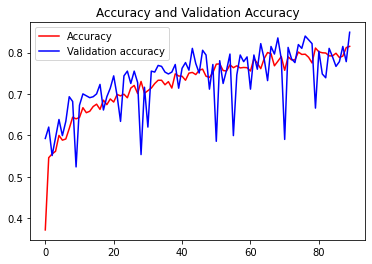

<Figure size 432x288 with 0 Axes>

In [34]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')

plt.title('Accuracy and Validation Accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

<Figure size 432x288 with 0 Axes>

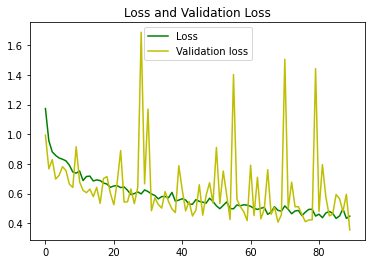

<Figure size 432x288 with 0 Axes>

In [35]:
plt.plot(epochs, loss, 'g', label='Loss')
plt.plot(epochs, val_loss, 'y', label='Validation loss')
plt.title('Loss and Validation Loss')
plt.legend(loc=0)
plt.figure()

In [38]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

class_list = ['cats','dogs' , 'panda']

for fn in uploaded.keys():
 
  # predicting images
  path = fn
  img = image.load_img(path, target_size=(150, 150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  prediction_list = classes.tolist()

  for i in range(len(class_list)):
    if prediction_list[0][i] >= 0.9:
        print("This is:" + class_list[i] + "!")

  print(fn)
  print('-Congrats this is working!-')
 

Saving WhatsApp Image 2021-07-17 at 21.51.04.jpeg to WhatsApp Image 2021-07-17 at 21.51.04 (1).jpeg
This is:cats!
WhatsApp Image 2021-07-17 at 21.51.04.jpeg
-Congrats this is working!-


In [39]:
import pathlib

source_file_name = "rps.h5"
destination_file_name = "rps.tflite"

model = tf.keras.models.load_model(source_file_name)

model.summary()

print("Converting...")

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tfmodel = converter.convert()
open (destination_file_name , "wb") .write(tfmodel)

print("File saved as TFlite!")

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 148, 148, 64)      1792      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 74, 74, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 72, 72, 64)        36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 15, 15, 128)      